# VAT moon data

In [9]:
import numpy as np
import pandas as pd 

import torch
import torch.utils.data

import matplotlib.pyplot as plt
import seaborn as sns
import visdom
viz = visdom.Visdom(env='VAT_test')

import sklearn.datasets
from sklearn.metrics import accuracy_score

In [10]:
X_all, y_all = sklearn.datasets.make_moons(n_samples=1000,shuffle=False,noise=0.1,random_state=41)
X0_all = X_all[y_all==0]
X1_all = X_all[y_all==1]
i_labeled = 400
half_n_labeled = 4

X0u = X0_all.copy()
X1u = X1_all.copy()

Xl, yl = sklearn.datasets.make_moons(n_samples=3*half_n_labeled,shuffle=False,noise=0.1,random_state=9)
X0l = Xl[yl==0][:half_n_labeled]
X1l = Xl[yl==1][:half_n_labeled]
Xl_new = np.r_[X0l,X1l]
yl_new = np.array([0,0,0,0,1,1,1,1])

In [11]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
ax.scatter(X0u[:,0],X0u[:,1],c='gray',label='unlabel')
ax.scatter(X1u[:,0],X1u[:,1],c='gray',label='unlabel')
ax.scatter(X0l[:,0],X0l[:,1],c='C0',label='0')
ax.scatter(X1l[:,0],X1l[:,1],c='C1',label='1')
ax.legend(loc='upper right', bbox_to_anchor=(1,1), fontsize=8)
viz.matplot(fig)
fig.clf()

<Figure size 216x216 with 0 Axes>

# VAT

In [12]:
import contextlib
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(2,100)
        self.linear2 = nn.Linear(100,100)
        self.linear3 = nn.Linear(100,100)
        self.linear4 = nn.Linear(100,2)
        
    def forward(self,x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = self.linear4(x)
        return x

In [14]:
@contextlib.contextmanager
def _disable_tracking_bn_stats(model):
    def switch_attr(m):
        if hasattr(m, 'track_running_stats'):
            m.track_running_stats ^= True
    
    model.apply(switch_attr)
    yield
    model.apply(switch_attr)
    
def normalize(d):
    d /= (torch.sqrt(torch.sum(d**2, axis=1)).view(-1,1)+1e-16)
    return d

def _l2_normalize(d):
    d_reshaped = d.view(d.shape[0], -1, *(1 for _ in range(d.dim() - 2)))
    d /= torch.norm(d_reshaped, dim=1, keepdim=True) + 1e-16
    return d

def _kl_div(p,q):
    '''
    D_KL(p||q) = Sum(p log p - p log q)
    '''
    logp = torch.nn.functional.log_softmax(p,dim=1)
    logq = torch.nn.functional.log_softmax(q,dim=1)
    p = torch.exp(logp)
    return (p*(logp-logq)).sum(dim=1,keepdim=True).mean()

class VATLoss(nn.Module):
    def __init__(self, xi =0.001, eps=0.1, ip=2):
        """
        VAT loss
        :param xi: hyperparameter of VAT.  a small float for the approx. of the finite difference method.
        :param eps: hyperparameter of VAT. the value for how much deviate from original data point X.
        :param ip: a number of power iteration for approximation of r_vadv. The default value 2 is sufficient.
        """
        super(VATLoss, self).__init__()
        self.xi = xi
        self.eps = eps
        self.ip = ip
        
    def forward(self, model, x):
        with torch.no_grad():
            pred = model(x)
        
        # random unit for perturbation
        d = torch.randn(x.shape)
        d = _l2_normalize(d)
        for _ in range(self.ip):
            d.requires_grad_()
            pred_hat = model(x + self.xi * d)
            adv_distance = _kl_div(pred_hat, pred)
            adv_distance.backward()
            d = _l2_normalize(d.grad.data)
            model.zero_grad()
        
        r_adv = d*self.eps
        pred_hat = model(x+r_adv)
        lds = _kl_div(pred_hat, pred)
        return lds

In [15]:
def train(u):
    vat_loss=VATLoss(ip=2,xi=0.5,eps=0.5)
    cross_entropy = nn.CrossEntropyLoss()
    lds = vat_loss(model,u.float())
    output = model(torch.tensor(Xl_new).float())
    classification_loss = cross_entropy(output, torch.tensor(yl_new))
    loss = classification_loss + 4.*lds
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return classification_loss, lds

def valid(win=None):
    model.eval()
    z_pred = torch.nn.functional.softmax(model(torch.from_numpy(X_all).float()),dim=1).data.numpy()[:,1]
    val = np.c_[X_all,z_pred.T]
    
    fig = plt.figure(figsize=[3,3])
    ax = fig.add_subplot(111)
    h = ax.scatter(X_all[:,0],X_all[:,1], c=z_pred, vmin=0, vmax=1,cmap='seismic')
    ax.scatter(X0l[:,0],X0l[:,1],c='C0',marker='s',s=100)
    ax.scatter(X1l[:,0],X1l[:,1],c='C1',marker='v',s=100)
    fig.colorbar(h)
    
    if win is not None:
        win = viz.matplot(fig,win=win)
    else:
        win = viz.matplot(fig)
    fig.clf()
    return win,val

In [16]:
#train 
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_all),torch.LongTensor(y_all))
win = None
picdata = []
for epoch in range(150):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=100,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        classification_loss, lds = train(u)

        ce_losses =classification_loss.item()
        vat_losses = lds.item()
        if i_total_step%100 == 0 or i_total_step==1:
            win, dat = valid(win)
            picdata.append(dat)
            if i_total_step==1:
                win2=viz.line(X=[i_total_step],Y=[[ce_losses,vat_losses,ce_losses+vat_losses]],opts=dict(legend=['ce_loss','vat_loss','tot']))
            else:
                viz.line(X=[i_total_step],Y=[[ce_losses,vat_losses,ce_losses+vat_losses]],win=win2,update='append',opts=dict(legend=['ce_loss','vat_loss','tot']))
#             print("CE:{0}".format(ce_losses))
#             print("Vat:{0}".format(vat_losses))
#             print("-----------------------------")

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

In [17]:
#train 
i_total_step = 0
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001, eps=0.001)
dataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_all),torch.LongTensor(y_all))
win = None
picdata_nom = []
for epoch in range(150):
    dataloader = torch.utils.data.DataLoader(dataset,batch_size=120,shuffle=True)
    for u , _ in dataloader:
        i_total_step +=1
        
        vat_loss=VATLoss()
        cross_entropy = nn.CrossEntropyLoss()
        
        output = model(torch.tensor(Xl_new).float())
        classification_loss = cross_entropy(output, torch.tensor(yl_new))
        
        loss = classification_loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        accuracy = accuracy_score(yl_new, np.argmax(output.data.numpy(),axis=1))
        ce_losses =classification_loss.item()

        if i_total_step%100 == 0 or i_total_step==1:
            win, dat = valid(win)
            picdata_nom.append(dat)
            if i_total_step==1:
                win2=viz.line(X=[i_total_step],Y=[[ce_losses,vat_losses,ce_losses+vat_losses]],opts=dict(legend=['ce_loss','vat_loss','tot']))
            else:
                viz.line(X=[i_total_step],Y=[[ce_losses,vat_losses,ce_losses+vat_losses]],win=win2,update='append',opts=dict(legend=['ce_loss','vat_loss','tot']))
#             print("CE:{0}".format(ce_losses))
#             print("Vat:{0}".format(vat_losses))
#             print("-----------------------------")

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

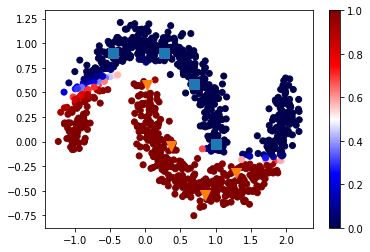

In [18]:
model.eval()
fig = plt.figure()
ax = fig.add_subplot(111)
z_pred = torch.nn.functional.softmax(model(torch.from_numpy(X_all).float()),dim=1).data.numpy()[:,1]
ax.scatter(X0l[:,0],X0l[:,1],c='C0',marker='s',s=100)
ax.scatter(X1l[:,0],X1l[:,1],c='C1',marker='v',s=100)
h = ax.scatter(X_all[:,0],X_all[:,1],c=z_pred,zorder=-1,cmap='seismic')
fig.colorbar(h)

In [43]:
import matplotlib.animation as animation

In [44]:
def updater(i,data,ax,fig):
    ax.cla()
    
    h = ax.scatter(x=data[i][:,0],y=data[i][:,1],c=data[i][:,2],vmin=0, vmax=1,cmap='seismic')
    c = ax.scatter(X0l[:,0],X0l[:,1],c='C0',marker='s',s=100)
    c = ax.scatter(X1l[:,0],X1l[:,1],c='C1',marker='v',s=100)

In [46]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
fig.colorbar(h)
ani = animation.FuncAnimation(fig,updater, fargs=(picdata,ax,fig),interval=5000,frames=len(picdata))
ani.save('VAT_train.gif',writer='imagemagick')
fig.clf()

<Figure size 216x216 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=[3,3])
ax = fig.add_subplot(111)
fig.colorbar(h)
ani = animation.FuncAnimation(fig,updater, fargs=(picdata_nom,ax,fig),interval=5000,frames=len(picdata_nom))
ani.save('Normal.gif',%%writefile)
fig.clf()